In [1]:
%load_ext autoreload
%autoreload 2

from modules.negative_set import generate_negative_set, get_box_parameters
from modules import data, models, descriptor_vector, validation, selection
from modules.selection import try_classifiers, try_params
import numpy as np
from skimage.transform import resize
import pickle
from pprint import pprint as pp

In [2]:
# Store
store = []

In [108]:
# Load data
full_images = data.load_images()
full_labels = data.load_labels()

In [133]:
# Global Params
OFFSET = 0
LIMIT = 100
NEG_SIZE = 150
TRAIN_RATE = 0.75

In [134]:
# Limit if needed
if LIMIT:
    images = full_images[OFFSET:OFFSET+LIMIT]
    labels = full_labels[full_labels[:,0] <= OFFSET+LIMIT]
    labels = labels[labels[:,0] > OFFSET]
else:
    images = full_images
    labels = full_labels
print(f"Using {len(images)}/{len(full_images)} images & {len(labels)}/{len(full_labels)} labels")

Using 100/1000 images & 134/1284 labels


In [135]:
# Label sets
print(f"Generating {NEG_SIZE} negatives...")
negatives = generate_negative_set(images, labels, set_size=NEG_SIZE)

print("Creating train & validation sets with negatives...")
all_labels = np.concatenate([labels, negatives])
train_labels, valid_labels = label_sets = data.train_valid_sets(len(images), all_labels, TRAIN_RATE)
print(f"Train: {len(np.unique(train_labels[:,0]))}, Valid: {len(np.unique(valid_labels[:,0]))}")

Generating 150 negatives...
Creating train & validation sets with negatives...
Train: 75, Valid: 25


In [136]:
# Global params
only_one_training = False
limit_score = 0.5
slide_step = (60,50)
downscale_step = 30
box_size = (150, 90)

# Model
CLASSIFIER = 'random_forest'
MODEL_PARAMS = {
    'n_estimators': 50,
    'class_weight': { -1: 1, 1: 1.2}
}
VECTORIZATION_PARAMS = {
    'vectorize': descriptor_vector.hog,
    'vectorize_args': [6],
} 

In [197]:
# ( 1 ) --- Single --- Train, predict, validate
clf = models.create_model(CLASSIFIER, MODEL_PARAMS)
kwargs = { 'limit_score': limit_score, 'slide_step': slide_step, 'downscale_step': downscale_step }

print("Training...")
train_results = models.train(clf, images, box_size, train_labels, **VECTORIZATION_PARAMS,
                             only_one_training=only_one_training, **kwargs)

print("Predicting with windows...")
valid_indexes = np.unique(valid_labels[:,0]) - 1
predictions = models.predict(clf, images, box_size, **VECTORIZATION_PARAMS, only=valid_indexes, **kwargs)

results = validation.rate_predictions(predictions, valid_labels)
print("Done")

print("\n------\n")
if results not in store: store.append(results)
pp(results)

Training...
First training...





Predicting windows:   0%|                                                                                                                                           | 0/100 [00:00<?, ?it/s]


Predicting windows:   1%|█▎                                                                                                                                 | 1/100 [00:01<01:57,  1.18s/it]


Predicting windows:   2%|██▌                                                                                                                                | 2/100 [00:01<01:35,  1.02it/s]


Predicting windows:   3%|███▉                                                                                                                               | 3/100 [00:02<01:33,  1.03it/s]


Predicting windows:   4%|█████▏                                                                                                                             | 4/100 [00:03<01:36,  1.00s/it]


Predicting windows:   5%|██████▌          

Adding 220 false positives / 295 predictions
Second training...
Predicting with windows...





Predicting windows:   0%|                                                                                                                                           | 0/100 [00:00<?, ?it/s]


Predicting windows:  11%|██████████████▎                                                                                                                   | 11/100 [00:01<00:15,  5.81it/s]


Predicting windows:  14%|██████████████████▏                                                                                                               | 14/100 [00:03<00:24,  3.45it/s]


Predicting windows:  15%|███████████████████▌                                                                                                              | 15/100 [00:05<01:06,  1.29it/s]


Predicting windows:  16%|████████████████████▊                                                                                                             | 16/100 [00:06<01:21,  1.03it/s]


Predicting windows:  20%|█████████████████

IndexError: too many indices for array

In [34]:
# ( 1bis ) --- Single --- Train, predict, validate
clf = models.create_model(CLASSIFIER, MODEL_PARAMS)
kwargs = { 'limit_score': limit_score, 'slide_step': slide_step, 'downscale_step': downscale_step }

print("Training...")
train_results = models.train(clf, images, box_size, train_labels, **VECTORIZATION_PARAMS,
                             only_one_training=only_one_training, **kwargs)

Training...
First training...


Predicting windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  2.21it/s]


Adding 10 false positives / 61 predictions
Second training...


In [ ]:
coordinates, windows = sliding_windows(img, box_size, slide_step, downscale_step)
print(coordinates.shape)
print(windows.shape)
print(descriptor_vector.hog(windows).shape)

In [167]:
img = images[49]
h, l = img.shape[:2]
r = h / l
s = downscale_step
box_h, box_l = box_size
gen = list(downscale_image(img, step=downscale_step, min_height=box_h, min_width=box_l))

n_scaled_img = 1 + int(min(
    ((h - box_h) / downscale_step),
    ((l - box_l) / (downscale_step/r)),
))

print(
    ((h - box_h) / downscale_step),
    ((l - box_l) / (downscale_step/r)),
)

print(n_scaled_img, len(gen), n_scaled_img == len(gen))
print("b", box_size, "s", downscale_step)
for i in gen:
    print(i.shape[:2])

10.0 10.99406528189911
11 10 False
b (150, 90) s 30
(450, 337)
(420, 314)
(390, 292)
(360, 269)
(330, 247)
(300, 224)
(270, 202)
(240, 179)
(210, 157)
(180, 134)


In [189]:
from modules.window import compute_no_windows
from random import randrange
i = randrange(len(full_images))
img = full_images[i]

n1 = compute_no_windows(img, box_size, slide_step, downscale_step)
n2 = sliding_windows(img, box_size, slide_step, downscale_step)
print(n1, n2, n1 == n2)

(5, 6)
(5, 5)
(4, 5)
(4, 4)
(3, 4)
(3, 3)
(2, 3)
(2, 2)
(1, 2)
(1, 2)
10
9
126 126 True


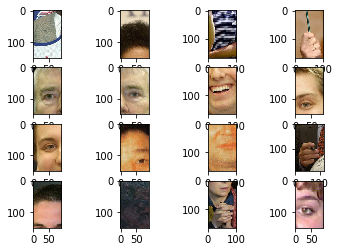

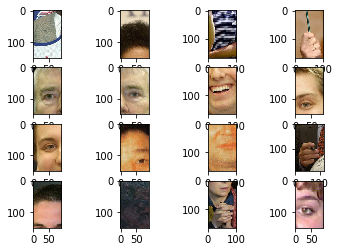

In [32]:
from skimage.io import imshow_collection
imgs = []
for falpos in train_results:
    img_id = falpos[0]
    x,y,h,l = falpos[1:5]
    img = images[img_id-1]
    imgs.append(img[x:x+h,y:y+l])
imshow_collection(imgs)

In [96]:
# ( 2 ) --- Multiple --- Try multiple params
clf_name = 'random_forest'
global_params = {
    # General
    'box_size': (150, 90),

    'n_estimators': 50,
    'class_weight': { -1: 1, 1: 1.2},

    'vectorization_params': {
        'vectorize': descriptor_vector.hog,
        'vectorize_args': [6],
    },
}

kwargs = {
    'limit_score': 0.5,
    'slide_step': (60,50),
    'downscale_step': 30,
    'only_one_training': True,
}

changing_params = {
    'box_size': [
        (150, 90),
        (160, 100),
        (170, 110),
        (170, 120),
    ]
}

results = try_params(images, label_sets, clf_name, global_params, changing_params, **kwargs)
print("\n------\n")
if results not in store: store.append(results)
pp(results)

## Trying parameter `box_size`...
### with value `(150, 90)`
First training...



Predicting windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  1.28it/s]

### with value `(160, 100)`
First training...



Predicting windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  1.09it/s]

### with value `(170, 110)`
First training...



Predicting windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  1.43it/s]

### with value `(170, 120)`
First training...



Predicting windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  1.13it/s]


------

{'classifier': 'random_forest',
 'global_params': {'class_weight': {-1: 1, 1: 1.2}, 'n_estimators': 50},
 'results': [{'name': 'box_size',
              'result': {'false_pos': 11,
                         'missing_predictions': 25,
                         'no_faces': 55,
                         'no_images': 40,
                         'no_predictions': 39,
                         'true_pos': 28},
              'value': (150, 90)},
             {'name': 'box_size',
              'result': {'false_pos': 9,
                         'missing_predictions': 25,
                         'no_faces': 55,
                         'no_images': 40,
                         'no_predictions': 36,
                         'true_pos': 27},
              'value': (160, 100)},
             {'name': 'box_size',
              'result': {'false_pos': 8,
                         'missing_predictions': 28,
                         'no_faces': 55,
                         'no_images': 40,
      